In [1]:
from models import VAE
from losses import VAE_Loss
import torch

In [2]:
# Example usage
input_shape = (3, 64, 64)  # Assuming RGB images of size 64x64
output_shape = (3, 64, 64)  # Same as input_shape
hidden_dims = [32, 64, 128]  # Hidden dimensions
latent_dim = 100  # Latent dimension

vae = VAE(input_shape, hidden_dims, latent_dim, output_shape)

In [3]:
batch_size = 32
x = torch.sigmoid(torch.randn(batch_size, *input_shape))

In [4]:
reconstructed, mu, logvar = vae.forward(
    x
)  # x is a torch.Tensor of shape (batch_size, *input_shape)
reconstructed.shape, mu.shape, logvar.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 100]), torch.Size([32, 100]))

Minimum value of x: 0.008595190942287445
Maximum value of x: 0.9891074299812317
Minimum value of reconstructed: 0.0034940820187330246
Maximum value of reconstructed: 0.9961540102958679


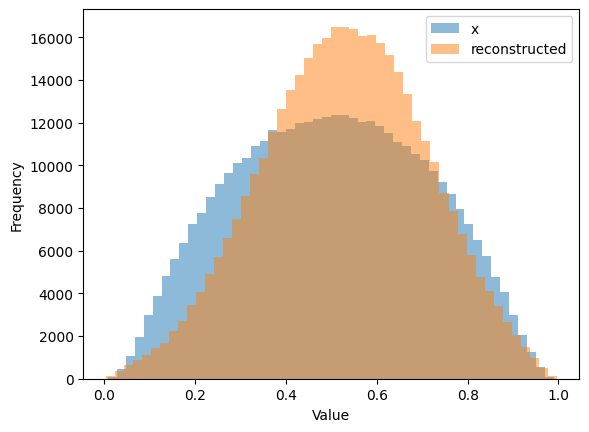

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Compare minimum and maximum values
x_min = torch.min(x).item()
x_max = torch.max(x).item()
reconstructed_min = torch.min(reconstructed).item()
reconstructed_max = torch.max(reconstructed).item()

print("Minimum value of x:", x_min)
print("Maximum value of x:", x_max)
print("Minimum value of reconstructed:", reconstructed_min)
print("Maximum value of reconstructed:", reconstructed_max)

# Compare distributions
x_values = x.flatten().detach().numpy()
reconstructed_values = reconstructed.flatten().detach().numpy()

plt.hist(x_values, bins=50, alpha=0.5, label='x')
plt.hist(reconstructed_values, bins=50, alpha=0.5, label='reconstructed')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [6]:
total_loss, recon_loss, regul_loss = VAE_Loss(x, reconstructed, mu, logvar)
print("Total loss:", total_loss.item())
print("Reconstruction loss:", recon_loss.item())
print("Regularization loss:", regul_loss.item())

Total loss: 317137.375
Reconstruction loss: 316729.75
Regularization loss: 407.62384033203125


In [20]:
import torchvision
import torchvision.transforms as transforms

# Define data transformation
transform = transforms.ToTensor()

# Load MNIST train and test datasets
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

class_label = 8  # Class label for digit 8
# Filter train dataset for class class_label
train_dataset_filtered = torch.utils.data.Subset(
    train_dataset,
    [i for i, (_, label) in enumerate(train_dataset) if label == class_label],
)

# Filter test dataset for class class_label
test_dataset_filtered = torch.utils.data.Subset(
    test_dataset,
    [i for i, (_, label) in enumerate(test_dataset) if label == class_label],
)

# # Create data loaders for filtered datasets
# train_loader_filtered = torch.utils.data.DataLoader(train_dataset_filtered, batch_size=64, shuffle=True)
# test_loader_filtered = torch.utils.data.DataLoader(test_dataset_filtered, batch_size=64, shuffle=False)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset_filtered, batch_size=64, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset_filtered, batch_size=64, shuffle=False
)

In [21]:
from tqdm import tqdm
# Function to train the VAE model
def train_vae(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (data, _) in enumerate(progress_bar):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, _, _ = VAE_Loss(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            progress_bar.set_postfix({"Loss": loss.item() / len(data)})
        print(
            "====> Epoch: {} Average loss: {:.4f}".format(
                epoch, total_loss / len(train_loader.dataset)
            )
        )

In [23]:
# Train the VAE model
vae_mnist = VAE(
    input_shape=(1, 28, 28),
    hidden_dims=[32, 64, 128],
    latent_dim=20,
    output_shape=(1, 28, 28),
)
vae_mnist

VAE(
  (encoder): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=2048, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=20, bias=True)
  (decoder): Sequential(
    (fc): Linear(in_features=20, out_features=2048, bias=True)
    (relu): ReLU()
    (reshape): Unflatten(dim=1, unflattened_size=(128, 4, 4))
    (conv_transpose1): ConvTranspose2d(128, 12

In [32]:
optimizer = torch.optim.Adam(vae_mnist.parameters(), lr=1e-3)
num_epochs = 40
train_vae(vae_mnist, train_loader, optimizer, num_epochs=num_epochs)

====> Epoch: 0 Average loss: 114.2435


====> Epoch: 1 Average loss: 112.1029


====> Epoch: 2 Average loss: 111.3069


====> Epoch: 3 Average loss: 110.5492


====> Epoch: 4 Average loss: 110.3603


====> Epoch: 5 Average loss: 109.9052


====> Epoch: 6 Average loss: 109.4684


====> Epoch: 7 Average loss: 109.0072


====> Epoch: 8 Average loss: 108.9100


====> Epoch: 9 Average loss: 108.4194


====> Epoch: 10 Average loss: 108.0676


====> Epoch: 11 Average loss: 107.7080


====> Epoch: 12 Average loss: 107.5160


====> Epoch: 13 Average loss: 107.4170


====> Epoch: 14 Average loss: 107.2011


====> Epoch: 15 Average loss: 106.8858


====> Epoch: 16 Average loss: 106.8739


====> Epoch: 17 Average loss: 106.5939


====> Epoch: 18 Average loss: 106.3219


====> Epoch: 19 Average loss: 106.1756


====> Epoch: 20 Average loss: 105.9040


====> Epoch: 21 Average loss: 105.8329


====> Epoch: 22 Average loss: 105.6942


====> Epoch: 23 Average loss: 105.6939


====> Epoch: 24 Average loss: 105.5237


====> Epoch: 25 Average loss: 105.3588


====> Epoch: 26 Average loss: 105.2740


====> Epoch: 27 Average loss: 105.2736


====> Epoch: 28 Average loss: 104.9414


====> Epoch: 29 Average loss: 104.7647


====> Epoch: 30 Average loss: 104.6768


====> Epoch: 31 Average loss: 104.7405


====> Epoch: 32 Average loss: 104.4498


====> Epoch: 33 Average loss: 104.4074


====> Epoch: 34 Average loss: 104.1622


====> Epoch: 35 Average loss: 104.2852


====> Epoch: 36 Average loss: 104.2944


====> Epoch: 37 Average loss: 104.1329


====> Epoch: 38 Average loss: 104.0058


====> Epoch: 39 Average loss: 103.8858


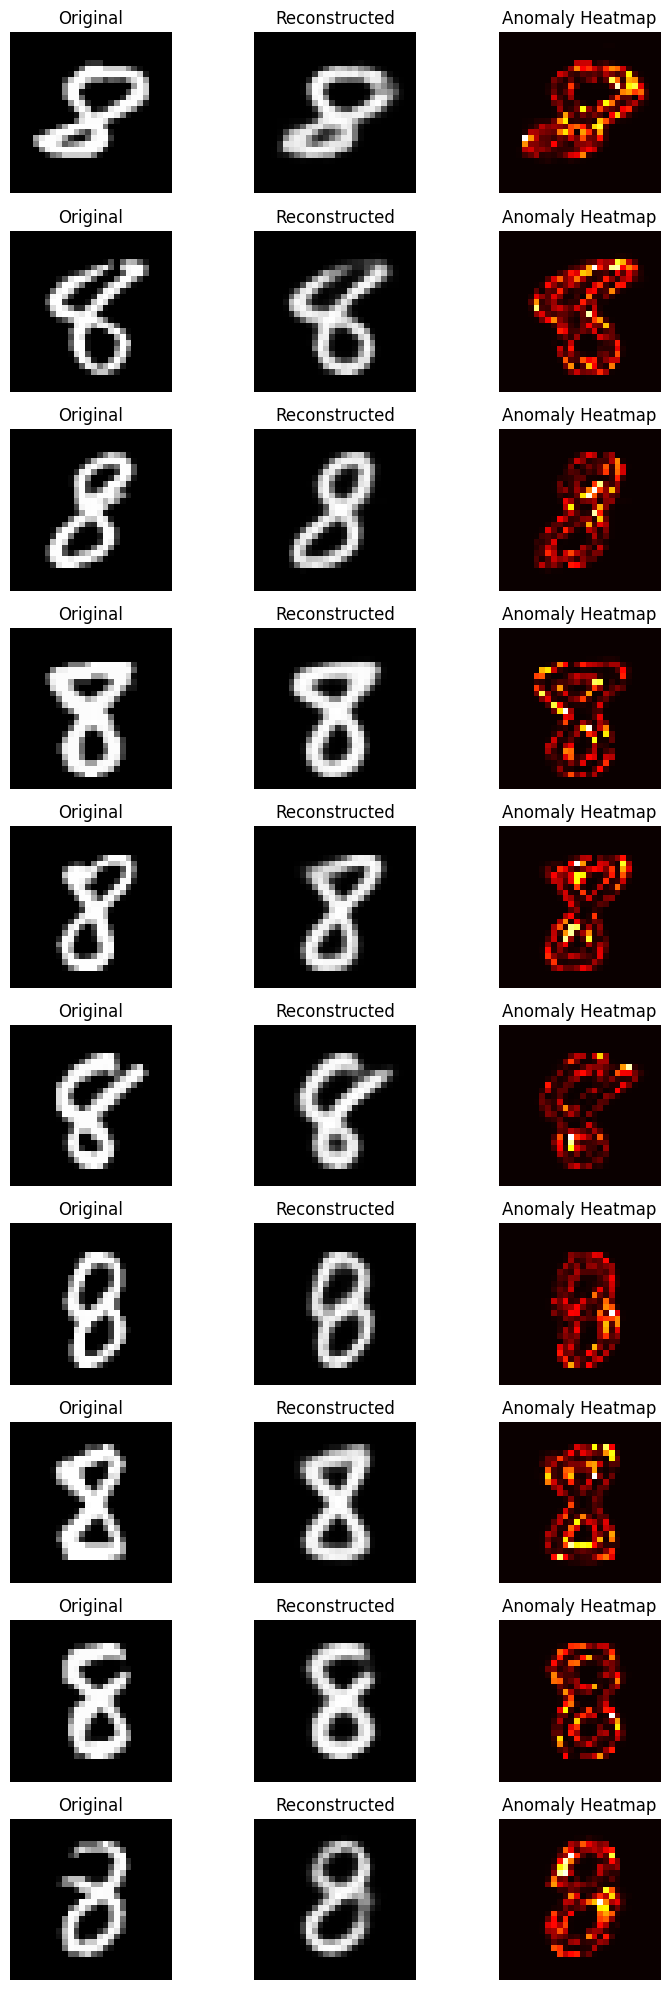

In [36]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_reconstructed_images_with_anomaly(model, test_loader, num_images=10):
    # Set the model to evaluation mode
    model.eval()

    # Sample a batch of images from the test loader
    images, _ = next(iter(test_loader))
    images = images[:num_images]

    # Generate reconstructed images using the model
    with torch.no_grad():
        reconstructed, _, _ = model(images)

    # Calculate the absolute difference between the original and reconstructed images
    diff = torch.abs(images - reconstructed)

    # Calculate the anomaly heatmap by summing the absolute differences across channels
    anomaly_heatmap = torch.sum(diff, dim=1, keepdim=True)

    # Plot the original, reconstructed, and anomaly heatmap images side by side
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2*num_images))
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Reconstructed')

        # Plot anomaly heatmap
        axes[i, 2].imshow(anomaly_heatmap[i].squeeze(), cmap='hot')
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Anomaly Heatmap')

    plt.tight_layout()
    plt.show()

# Call the function to plot reconstructed images with anomaly heatmap
plot_reconstructed_images_with_anomaly(vae_mnist, test_loader)


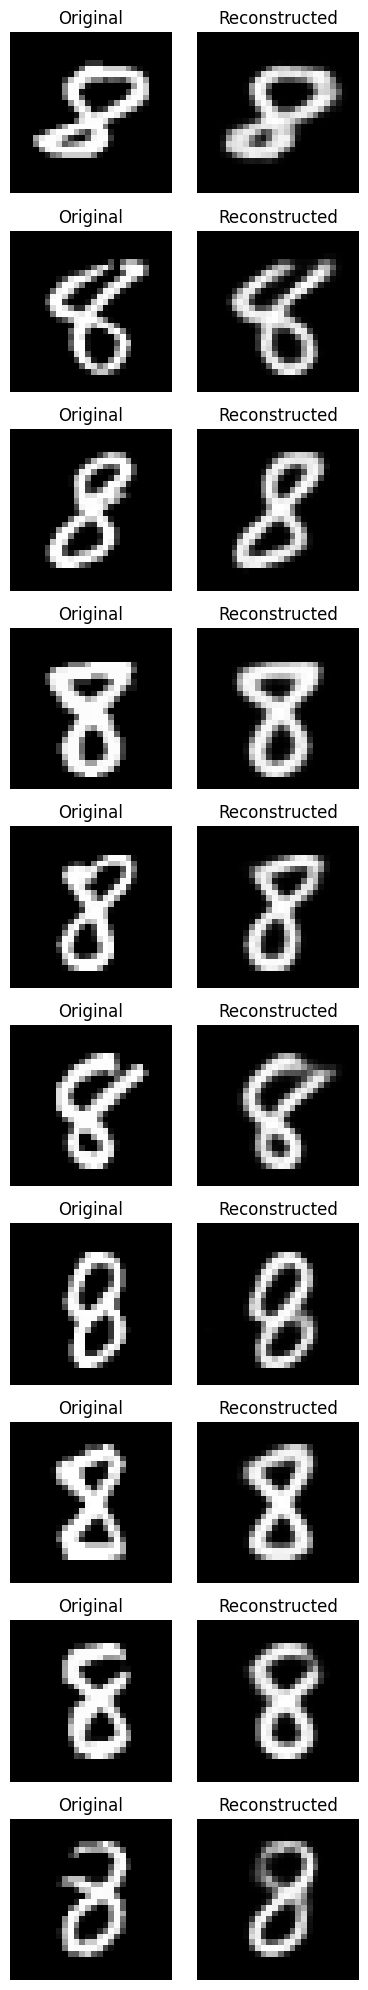

In [33]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_reconstructed_images(model, test_loader, num_images=10):
    # Set the model to evaluation mode
    model.eval()

    # Sample a batch of images from the test loader
    images, _ = next(iter(test_loader))
    images = images[:num_images]

    # Generate reconstructed images using the model
    with torch.no_grad():
        reconstructed, _, _ = model(images)

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(num_images, 2, figsize=(4, 2*num_images))
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Call the function to plot reconstructed images
plot_reconstructed_images(vae_mnist, test_loader)
